<a href="https://colab.research.google.com/github/portex33/MScASDF/blob/main/Scenario2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation


**Generate synthetic data to work on.**

In [34]:
from random import seed
from random import randint
from datetime import datetime, timedelta
from numpy import random
import numpy as np


#check if file exists and delete it
import os
if os.path.exists("data2.csv"):
  os.remove("data2.csv")


#write headings
f = open("data2.csv", "a")
f.write("timestamp,userid,customerid,views\n")

#Generate array of number of views on a normal distribution
viewsarr = np.random.normal(loc=11, scale=8, size=3000).astype(int)


specific_date = datetime(2021, 1, 1)

#Write data for 100 users over 30 days, with 100,000 possible customers
for days in range(30):
    for users in range(100):
        views = np.abs(viewsarr[users * days])
        f = open("data2.csv", "a")
        new_date = specific_date + timedelta(days)

#write views for each agent
        i = views
        while i > 0:
          custid = random.randint(0, 100000)
          dist = random.randint(0, 500)
          if dist == 499:
           views = 3
          elif dist >= 420:
           views = 2
          else:
            views = 1


          # write to file
          f.write(str(new_date) + ", " + str(users) + ", " + str(custid) + ", " + str(views) + "\n")

          i -= 1
          
#the final line doesn't write without the following code
f = open("data2.csv", "a")



# Visualise the Data

**Import and setup graphing libraries**

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


**Read the file and display dataframe**

In [36]:

df = pd.read_csv('data2.csv')
df


timestamp  userid  customerid  views
0      2021-01-01 00:00:00       0       67693      1
1      2021-01-01 00:00:00       0       29672      1
2      2021-01-01 00:00:00       0       35690      1
3      2021-01-01 00:00:00       0       26694      2
4      2021-01-01 00:00:00       0       39681      2
...                    ...     ...         ...    ...
32131  2021-01-30 00:00:00      98       31843      2
32132  2021-01-30 00:00:00      99       34325      1
32133  2021-01-30 00:00:00      99       63522      1
32134  2021-01-30 00:00:00      99        4585      2
32135  2021-01-30 00:00:00      99       47543      1

[32136 rows x 4 columns]

**Convert timestamp to pandas datetime format**

In [37]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

**Generate plot of the data - views by weeks**

In [38]:
df.columns.values
df = df.rename(columns={' views': 'views'}) 

x = df.timestamp
y = df.views
#df.plot.bar (x='week', y='views')


fig = px.scatter(df.reset_index(), x='timestamp', y='views', title='Agent Weekly Customer Views')
fig.show()

**Seed the data with some potential anomalies and regraph**

In [39]:
df.loc[999, 'views'] = 4
df.loc[777, 'views'] = 6



x = df.timestamp
y = df.views
fig = px.scatter(df.reset_index(), x='timestamp', y='views', title='Agent Weekly Customer Views')
fig.show()

# Prophet Anomaly Detection

In [40]:
from fbprophet import Prophet

#Rename columns as Prophet expects columns to be named ds (timestamp) and y (data).
model_df = df.reset_index()[['timestamp', 'views']].rename({'timestamp':'ds', 
                                                           'views':'y'}, 
                                                          axis='columns')



**Train the model**

In [41]:
#train with first 15 days
#find the last row where date is 15th January
lastrow = model_df[(model_df.ds=="2021-01-15")].tail(1)
train = model_df[0:lastrow.index[0]]

#test with last 15 days
last = len(df)-1
test = model_df[lastrow.index[0]+1:last]

In [42]:
model = Prophet(daily_seasonality=True)
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


**Forecast future values**

In [43]:
future = model.make_future_dataframe(periods=15,freq='D')
forecast = model.predict(future)


In [44]:
results = pd.concat([model_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]],
                    axis=1)
results

y      yhat  yhat_lower  yhat_upper
ds                                             
2021-01-01  1  1.179122    0.677595    1.622040
2021-01-01  1  1.179122    0.677595    1.622040
2021-01-01  1  1.179122    0.677595    1.622040
2021-01-01  2  1.179122    0.677595    1.622040
2021-01-01  2  1.179122    0.677595    1.622040
...        ..       ...         ...         ...
2021-01-30  2  1.191939    0.705287    1.705096
2021-01-30  1  1.191939    0.705287    1.705096
2021-01-30  1  1.191939    0.705287    1.705096
2021-01-30  2  1.191939    0.705287    1.705096
2021-01-30  1  1.191939    0.705287    1.705096

[32136 rows x 4 columns]

**Visualise forecast trends**

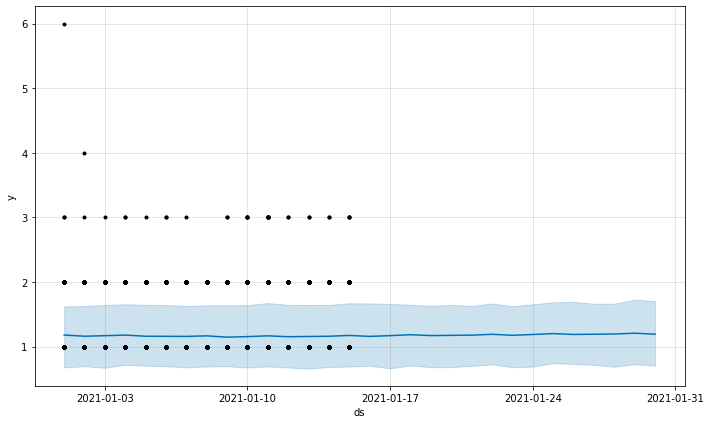

In [45]:
fig1 = model.plot(forecast)

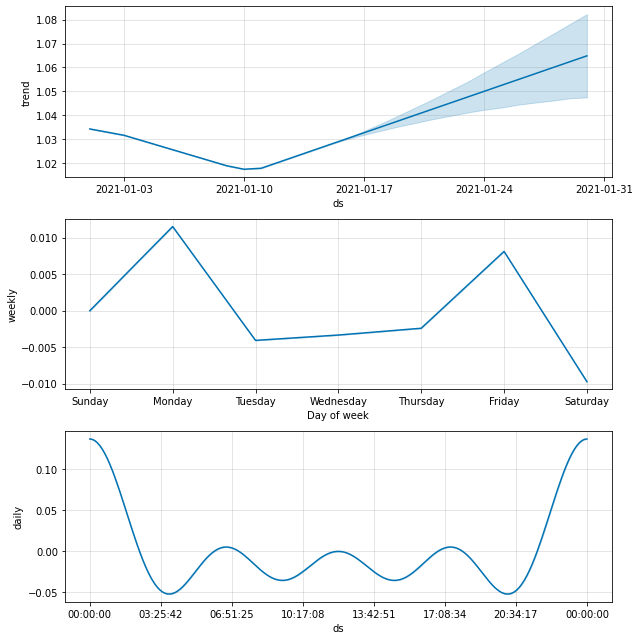

In [46]:
comp = model.plot_components(forecast)

**calculate error and uncertainty values**

In [47]:
results
results['error'] = results['y'] - results['yhat'] 
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']

In [48]:
results[results['error'].abs()>1*results['uncertainity']]

y      yhat  yhat_lower  yhat_upper     error  uncertainity
ds                                                                     
2021-01-01  3  1.179122    0.677595    1.622040  1.820878      0.944445
2021-01-01  3  1.179122    0.677595    1.622040  1.820878      0.944445
2021-01-01  6  1.179122    0.677595    1.622040  4.820878      0.944445
2021-01-02  4  1.159965    0.695969    1.627718  2.840035      0.931748
2021-01-02  3  1.159965    0.695969    1.627718  1.840035      0.931748
...        ..       ...         ...         ...       ...           ...
2021-01-26  3  1.187668    0.730318    1.693019  1.812332      0.962701
2021-01-27  3  1.190880    0.717402    1.662883  1.809120      0.945481
2021-01-27  3  1.190880    0.717402    1.662883  1.809120      0.945481
2021-01-30  3  1.191939    0.705287    1.705096  1.808061      0.999809
2021-01-30  3  1.191939    0.705287    1.705096  1.808061      0.999809

[68 rows x 6 columns]

**Find anomalies**

In [65]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>x['uncertainity']) else 'No',axis=1)
results

y      yhat  yhat_lower  ...  uncertainity  anomaly  anomaly2
ds                                   ...                                 
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
...        ..       ...         ...  ...           ...      ...       ...
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No

[32136 rows x 8 columns]

In [66]:
fig = px.scatter(results.reset_index(), x='ds', y='y', labels={
                     "ds": "ds (days)",
                     "y": "y (views)"
                      }
                 , color='anomaly',title='Agent Total Views Per Customer')
fig.show()

In [51]:
newdf = results[(results.anomaly=="Yes")]
newdf



y      yhat  yhat_lower  yhat_upper     error  uncertainity anomaly
ds                                                                             
2021-01-01  6  1.179122    0.677595    1.622040  4.820878      0.944445     Yes
2021-01-02  4  1.159965    0.695969    1.627718  2.840035      0.931748     Yes

# Standard Deviation Approach


In [63]:
std_dev = results['y'].std()
mean = results['y'].mean()

threshold = mean + (3*std_dev)
results['anomaly2'] = results.apply(lambda x: 'Yes' if(x['y'] > threshold) else 'No',axis=1)
results


y      yhat  yhat_lower  ...  uncertainity  anomaly  anomaly2
ds                                   ...                                 
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
...        ..       ...         ...  ...           ...      ...       ...
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No

[32136 rows x 8 columns]

In [64]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly2',labels={
                     "ds": "ds (days)",
                     "y": "y (views)"
                      },title='Agent Total Views Per Customer')
fig.show()

# Model Refinement

**Prophet Model**


In [58]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>2.2*x['uncertainity']) else 'No',axis=1)
results

y      yhat  yhat_lower  ...  uncertainity  anomaly  anomaly2
ds                                   ...                                 
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
...        ..       ...         ...  ...           ...      ...       ...
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No

[32136 rows x 8 columns]

In [59]:
fig = px.scatter(results.reset_index(), x='ds', y='y', labels={
                     "ds": "ds (days)",
                     "y": "y (views)"
                      }
                 , color='anomaly',title='Agent Total Views Per Customer')
fig.show()

**Standard Deviation Model**

In [60]:
std_dev = results['y'].std()
mean = results['y'].mean()

threshold = mean + (5*std_dev)
results['anomaly2'] = results.apply(lambda x: 'Yes' if(x['y'] > threshold) else 'No',axis=1)
results

y      yhat  yhat_lower  ...  uncertainity  anomaly  anomaly2
ds                                   ...                                 
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  1  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
2021-01-01  2  1.179122    0.677595  ...      0.944445       No        No
...        ..       ...         ...  ...           ...      ...       ...
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  2  1.191939    0.705287  ...      0.999809       No        No
2021-01-30  1  1.191939    0.705287  ...      0.999809       No        No

[32136 rows x 8 columns]

In [61]:
fig = px.scatter(results.reset_index(), x='ds', y='y', labels={
                     "ds": "ds (days)",
                     "y": "y (views)"
                      }
                 , color='anomaly',title='Agent Total Views Per Customer')
fig.show()